In [1]:
# 设定data路径
import os
os.chdir(r'F:\Study\Study Files\05大三上\金融统计分析\实验课1\1_Rawdata')

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
data = pd.read_csv('TRD_Mnth.csv')
data = data.drop(['Markettype'], axis=1)

In [3]:
forming_month_j = [1, 3, 6]
holding_month_k = [1, 3, 6]
winners_and_losers_count = 1000

trade_begin = '2022-01-01'
trade_end = '2022-12-31'

In [4]:
# 确保数据按股票代码和日期排序
data = data.sort_values(['Stkcd', 'Trdmnt'])
data['Trdmnt'] = pd.to_datetime(data['Trdmnt'])

# 设置回测期
data_trade = data[(data['Trdmnt'] >= trade_begin) & (data['Trdmnt'] <= trade_end)]

# 初始化一个3x3的DataFrame来保存不同策略的收益
result = pd.DataFrame(index=forming_month_j, columns=holding_month_k)

# 获取唯一的年月，作为回测的月份点
# unique_year_month = data_trade['Trdmnt'].dt.to_period('M').unique()
#unique_year_month = data_trade['Trdmnt'].unique()
unique_year_month = pd.PeriodIndex(data_trade['Trdmnt'].dt.to_period('M').unique())

In [5]:
# 开始循环：不同形成期和持有期
for form_period in forming_month_j:
    for hold_period in holding_month_k:

        all_returns = []
        all_returns_winners = []
        all_returns_losers = []
        past_winners = []
        past_losers = []

        # 根据hold_period生成额外的月份
        extra_months = pd.PeriodIndex([unique_year_month[-1] + i for i in range(1, hold_period)], freq='M')
        full_year_month = unique_year_month.union(extra_months)

        # 遍历每一个唯一的年月，包括额外的月份
        for current_ym in full_year_month:

            end_date = pd.to_datetime(current_ym.to_timestamp())
            start_date = end_date - pd.DateOffset(months=form_period)

            mask = (data['Trdmnt'] > start_date) & (data['Trdmnt'] <= end_date)
            form_returns = data.loc[mask].groupby('Stkcd')['Mretwd'].apply(lambda x: (1 + x).prod() - 1)

            available_stocks = data.loc[data['Trdmnt'] > end_date]['Stkcd'].unique()
            form_returns = form_returns[form_returns.index.isin(available_stocks)]

            winners = form_returns.nlargest(winners_and_losers_count).index.tolist()
            losers = form_returns.nsmallest(winners_and_losers_count).index.tolist()

            past_winners.append(winners)
            past_losers.append(losers)

            # 如果我们的列表变得过长，就移除旧的元素
            if len(past_winners) > hold_period:
                past_winners.pop(0)
                past_losers.pop(0)
            
            current_ym_str = str(current_ym)
            current_ym_datetime = pd.to_datetime(current_ym.to_timestamp()).to_pydatetime()

            if current_ym_datetime > (end_date + pd.DateOffset(months=hold_period)):
                num_to_remove = current_ym_datetime - (end_date + pd.DateOffset(months=hold_period))
                past_winners = past_winners[num_to_remove:]
                past_losers = past_losers[num_to_remove:]

            
            # 计算当月所有past_winners和past_losers的平均收益
            mask = (data['Trdmnt'] == str(current_ym))
            current_winner_returns = [
                data.loc[mask & data['Stkcd'].isin(winners_month)]['Mretwd'].mean() 
                for winners_month in past_winners
            ]
            current_loser_returns = [
                data.loc[mask & data['Stkcd'].isin(losers_month)]['Mretwd'].mean() 
                for losers_month in past_losers
            ]
            
            # 取算数平均
            current_winner_return = np.nanmean(current_winner_returns)
            current_loser_return = np.nanmean(current_loser_returns)

            # 计算策略收益：赢家收益 - 输家收益
            #strategy_return = current_winner_return - current_loser_return
            all_returns_winners.append(current_winner_return)
            all_returns_losers.append(current_loser_return)

        # 移除nan，计算几何平均等
        all_returns_winners_clean = [x for x in all_returns_winners if not np.isnan(x)]
        all_returns_losers_clean = [x for x in all_returns_losers if not np.isnan(x)]

        cumulative_returns_winners = [x + 1 for x in all_returns_winners_clean]
        cumulative_returns_losers = [x + 1 for x in all_returns_losers_clean]

        geometric_mean_winners = np.prod(cumulative_returns_winners)**(1/len(cumulative_returns_winners)) - 1
        geometric_mean_losers = np.prod(cumulative_returns_losers)**(1/len(cumulative_returns_losers)) - 1

        annual_returns_winners = (geometric_mean_winners + 1) ** 12 - 1
        annual_returns_losers = (geometric_mean_losers + 1) ** 12 - 1

        annual_returns = annual_returns_winners - annual_returns_losers

        result.loc[form_period, hold_period] = annual_returns


C:\Users\Herry\AppData\Local\Temp\ipykernel_5360\2543176143.py:59: RuntimeWarning: Mean of empty slice
  current_winner_return = np.nanmean(current_winner_returns)
C:\Users\Herry\AppData\Local\Temp\ipykernel_5360\2543176143.py:60: RuntimeWarning: Mean of empty slice
  current_loser_return = np.nanmean(current_loser_returns)


In [6]:
print(result)

          1         3         6
1  6.202674  1.324314  1.066941
3  2.668299  0.657949  0.545286
6  1.524288  0.380566  0.388815


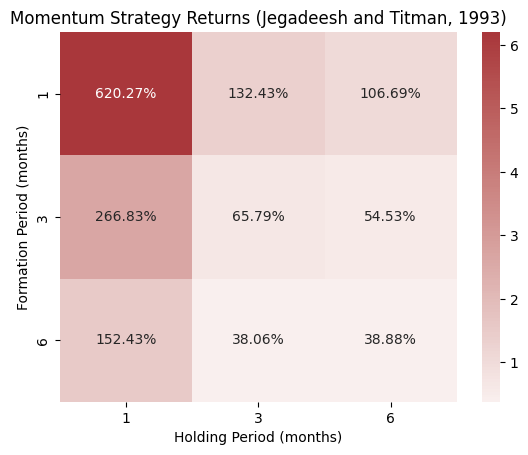

In [7]:
sns.heatmap(result.astype(float), annot=True, fmt=".2%", cmap="vlag", center=0)
plt.title("Momentum Strategy Returns (Jegadeesh and Titman, 1993)")
plt.xlabel("Holding Period (months)")
plt.ylabel("Formation Period (months)")
output_pic_file_name = "Momentum_Strategy_heatmap_" + trade_begin + "_" + trade_end + ".png"
plt.savefig(output_pic_file_name)
plt.show()